In [60]:
### Si données locales
u.user <- read.csv(file='u.user.csv', sep='|', header=T)
u.item <- read.csv(file='u.item.csv', sep='|', header=T)
u.data <- read.csv(file='u.data.csv', sep='|', header=T)
library(Matrix)
m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m.sparse) <- paste('u', 1:nrow(m.sparse), sep='')
colnames(m.sparse) <- paste('i', 1:ncol(m.sparse), sep='')

m <- as.matrix(m.sparse)                # transforme en matrice ordinaire

mae.rmse <- function(m, m.hat) {
    return(list(mae=mean(abs(m - m.hat), na.rm=T), rmse=sqrt(mean((m - m.hat)^2, na.rm=T))))
}
new.m.mae.rmse <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae.rmse(m.svd2, m)
    }

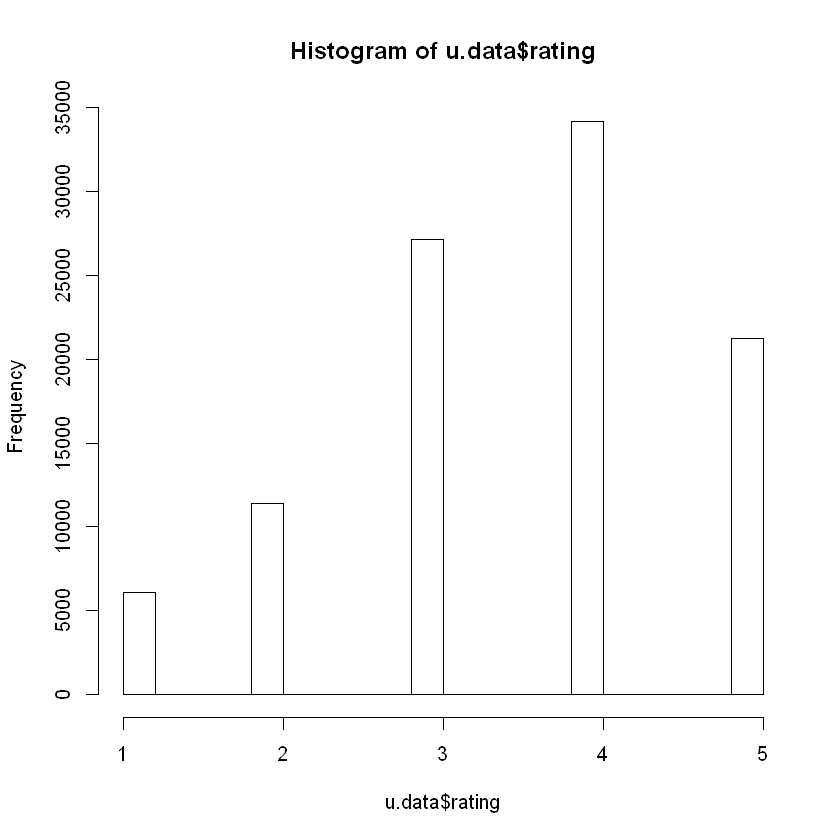

In [61]:
hist.values <- hist(u.data$rating)

$breaks
 [1] 1.0 1.2 1.4 1.6 1.8 2.0 2.2 2.4 2.6 2.8 3.0 3.2 3.4 3.6 3.8 4.0 4.2 4.4 4.6
[20] 4.8 5.0

$counts
 [1]  6110     0     0     0 11370     0     0     0     0 27145     0     0
[13]     0     0 34174     0     0     0     0 21201

$density
 [1] 0.30550 0.00000 0.00000 0.00000 0.56850 0.00000 0.00000 0.00000 0.00000
[10] 1.35725 0.00000 0.00000 0.00000 0.00000 1.70870 0.00000 0.00000 0.00000
[19] 0.00000 1.06005

$mids
 [1] 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3 3.5 3.7 3.9 4.1 4.3 4.5 4.7
[20] 4.9

$xname
[1] "u.data$rating"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"

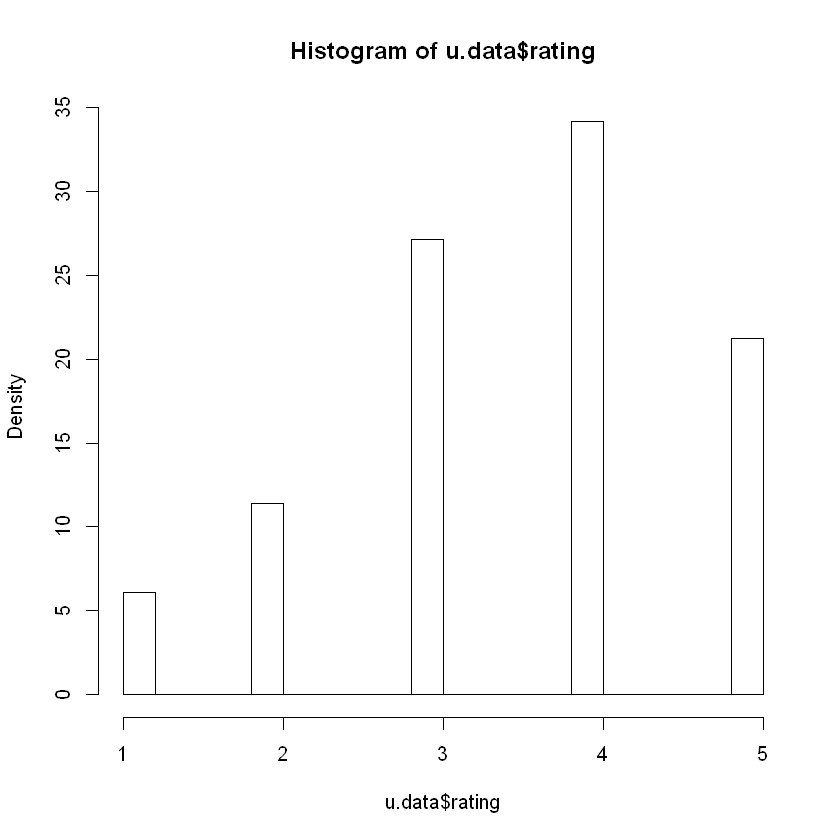

In [75]:
hist.values
hist.values$density = hist.values$counts/sum(hist.values$counts)*100
plot(hist.values,freq=FALSE)

In [63]:
hist.prob <- round(100*hist.values$counts/sum(hist.values$counts))

In [64]:
hist.prob

[1]  6  0  0  0 11  0  0  0  0 27  0  0  0  0 34  0  0  0  0 21

In [65]:
rand.dist <- rep(1,6*16000)

In [66]:
sum(m==0)

[1] 1486126

In [67]:
rand.dist <- c(rand.dist, rep(2,11*16000))
rand.dist <- c(rand.dist, rep(3,27*16000))
rand.dist <- c(rand.dist, rep(4,34*16000))
rand.dist <- c(rand.dist, rep(5,21*16000))

In [68]:
sample(rand.dist,1)

[1] 2

In [69]:
m[m==0]<-sample(rand.dist,sum(m==0))

In [70]:
m

,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,...,i1673,i1674,i1675,i1676,i1677,i1678,i1679,i1680,i1681,i1682
u1,5,3,4,3,3,5,4,1,5,3,...,4,4,4,4,4,3,2,5,4,3
u2,4,4,3,3,3,2,4,4,5,2,...,2,4,3,4,3,3,5,5,3,5
u3,4,4,4,5,2,4,4,2,5,3,...,3,4,4,4,4,3,2,5,5,4
u4,5,4,5,3,3,5,4,4,2,1,...,5,4,4,4,3,4,3,5,4,3
u5,4,3,4,3,4,1,4,4,3,3,...,3,5,3,4,2,3,3,4,4,4
u6,4,4,2,4,5,2,2,4,4,5,...,3,5,3,5,4,4,4,5,5,3
u7,4,3,1,5,3,3,5,5,5,4,...,4,1,4,3,2,4,2,2,3,5
u8,5,4,4,4,5,2,3,2,5,4,...,3,5,4,5,4,4,3,3,4,4
u9,3,2,4,5,4,5,4,3,4,4,...,4,3,4,4,4,2,3,4,2,5
u10,4,3,2,4,5,3,4,5,4,5,...,2,3,4,4,5,2,2,5,3,4


In [71]:
m.svd <- svd(m)



In [72]:
new.m.mae.rmse(10)

$mae
[1] 0.9108115

$rmse
[1] 1.102745

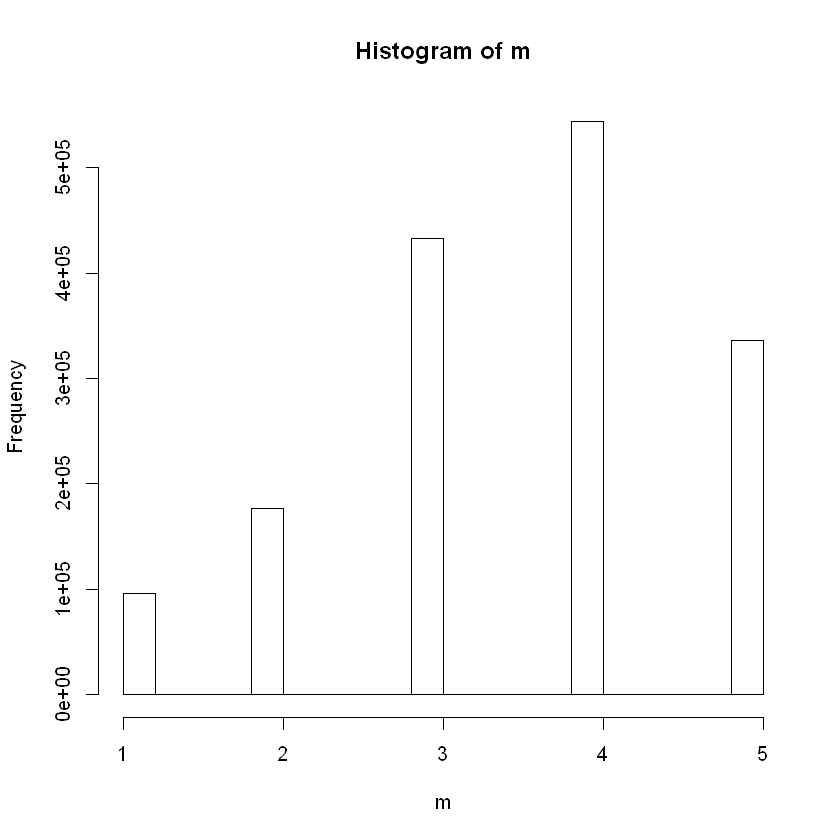

In [79]:
hist.values2 <- hist(m)
hist.values2$density = hist.values2$counts/sum(hist.values2$counts)*100


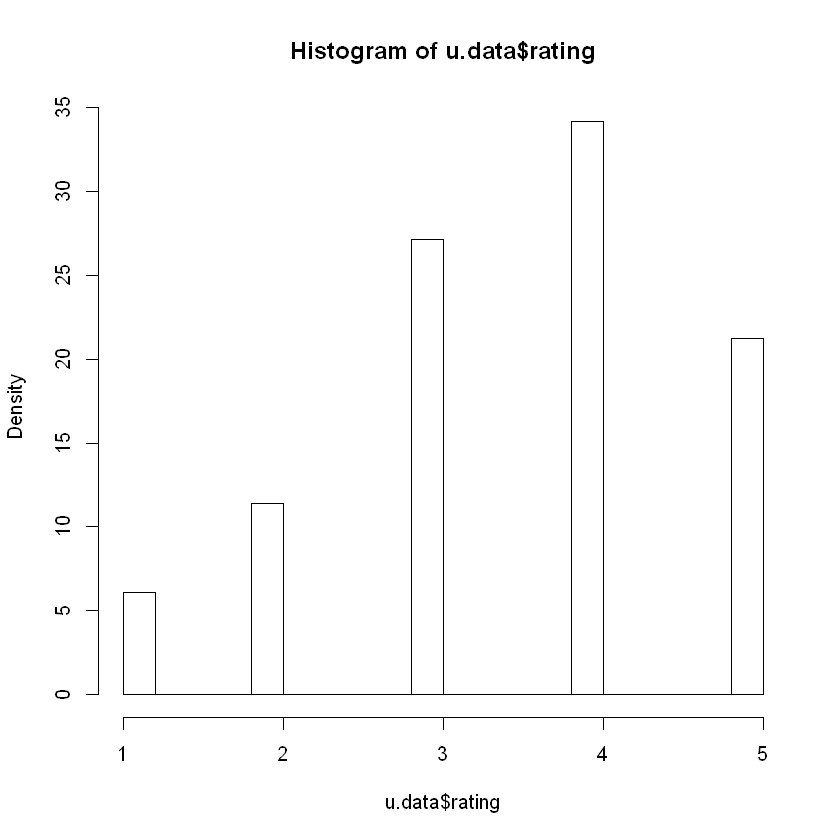

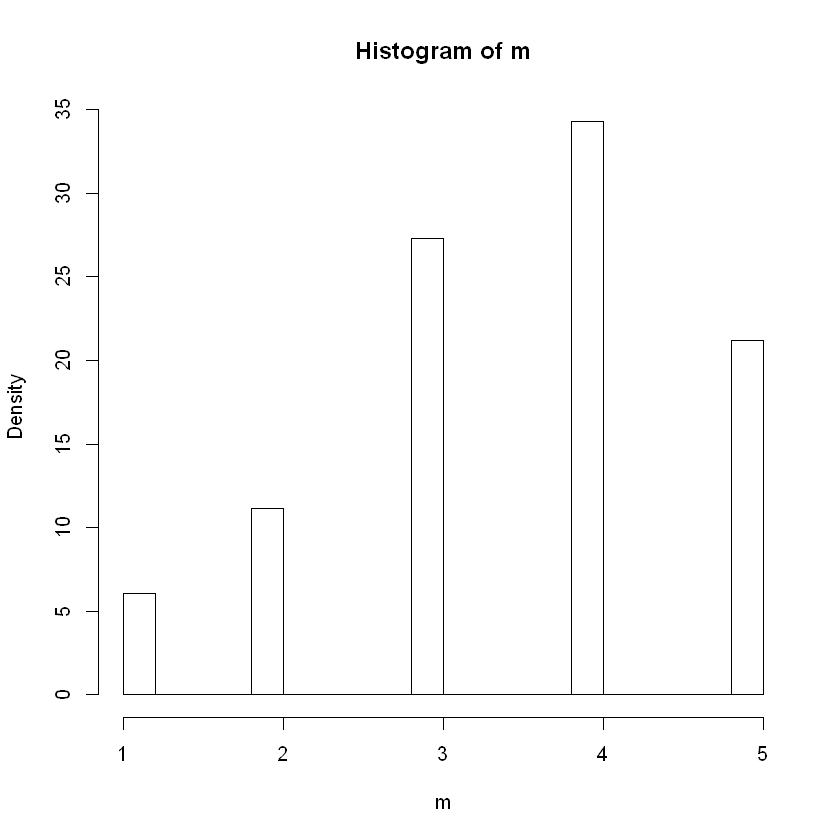

In [80]:
plot(hist.values,freq=FALSE)
plot(hist.values2,freq=FALSE)